# Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from helpers import parse_variables, map_to_color
from matplotlib.colors import LinearSegmentedColormap
import importlib.util

# Create population grid

In [2]:
dict = parse_variables('geno_simulation.txt')
if 'G' not in globals():
    G = int(dict['G'])
if 'L' not in globals():
    L = int(dict['L'])
if 'c' not in globals():
    c = int(dict['c'])
if 'k' not in globals():
    k = int(dict['k'])
if 'M' not in globals():
    M = float(dict['M'])
if 'HWE' not in globals():
    HWE = int(dict['HWE'])

if 'tools' not in globals():
    tools = ['PCA', 'abyss_counted', 'abyss', 'no_corr']


if 'scenarios' not in globals():
    scenarios = ['snp_effect',
                 'linear_continuous',
                 'non_linear_continuous',
                 'discrete_global',
                 'discrete_localized',
                 'mix_linear_continuous',
                 'mix_non_linear_continuous',
                 'mix_discrete_global',
                 'mix_discrete_localized']

if 'very_rare_threshold_L' not in globals():
    very_rare_threshold_L = float(dict['very_rare_threshold_L'])
if 'very_rare_threshold_H' not in globals():
    very_rare_threshold_H = float(dict['very_rare_threshold_H'])
if 'rare_threshold_L' not in globals():
    rare_threshold_L = float(dict['rare_threshold_L'])
if 'rare_threshold_H' not in globals():
    rare_threshold_H = float(dict['rare_threshold_H'])
if 'common_threshold_L' not in globals():
    common_threshold_L = float(dict['common_threshold_L'])
if 'common_threshold_H' not in globals():
    common_threshold_H = float(dict['common_threshold_H'])

In [3]:
number_of_snps = (G*L)/2 # one loci per chromosome
number_of_individuals = c*k*k

# load populations

In [4]:
populations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/phenotype/01_population_structure.pkl")
populations

,populations,x,y,z
0,pop 1,1,1,0.5
1,pop 1,1,1,0.5
2,pop 1,1,1,0.5
3,pop 1,1,1,0.5
4,pop 1,1,1,0.5
...,...,...,...,...
1995,pop 100,10,10,0.5
1996,pop 100,10,10,0.5
1997,pop 100,10,10,0.5
1998,pop 100,10,10,0.5


In [5]:
palette = [map_to_color(x, y, z, populations) for x, y, z in zip(populations['x'], populations['y'], populations['z'])]

In [6]:
# Extract integers from the 'populations' column and convert to integers
populations['population'] = populations['populations'].str.extract('(\d+)').astype(int)

In [7]:
populations["population_number"] = populations['population']/populations['population'].max()
populations

,populations,x,y,z,population,population_number
0,pop 1,1,1,0.5,1,0.01
1,pop 1,1,1,0.5,1,0.01
2,pop 1,1,1,0.5,1,0.01
3,pop 1,1,1,0.5,1,0.01
4,pop 1,1,1,0.5,1,0.01
...,...,...,...,...,...,...
1995,pop 100,10,10,0.5,100,1.00
1996,pop 100,10,10,0.5,100,1.00
1997,pop 100,10,10,0.5,100,1.00
1998,pop 100,10,10,0.5,100,1.00


In [8]:
"""
# Check the grid
df_agg = populations.groupby(['x', 'y']).agg({'population': 'mean'}).reset_index()

# Now, pivot the aggregated DataFrame
grid_df = df_agg.pivot(index='y', columns='x', values='population')

# Use seaborn to create the heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(grid_df, cmap=palette, linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title('Population Grid', fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()
"""

"\n# Check the grid\ndf_agg = populations.groupby(['x', 'y']).agg({'population': 'mean'}).reset_index()\n\n# Now, pivot the aggregated DataFrame\ngrid_df = df_agg.pivot(index='y', columns='x', values='population')\n\n# Use seaborn to create the heatmap\nplt.figure(figsize=(10, 10))\nheatmap = sns.heatmap(grid_df, cmap=palette, linewidths=.5, square=True, cbar=False)\n\n# Add a title to the heatmap\nplt.title('Population Grid', fontsize=16)\nplt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation\nplt.show()\n"

# Create and Observe PC's

In [9]:
very_rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/genotype/01_veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")
rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/genotype/01_rare_genotype_AF_{rare_threshold_L}_{rare_threshold_H}.pkl")
common = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/genotype/01_common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")

In [10]:
complete = pd.concat([common, rare, very_rare], axis=1)

In [11]:
try:
    scaler = StandardScaler()
    scaled_complete = scaler.fit_transform(complete)
    n_components = max(min(complete.shape[1], 50), 4)
    pca = PCA(n_components=n_components)
    pc_labels_complete = [f"PC{i}" for i in range(1, n_components + 1)]
    PC_complete = pca.fit_transform(scaled_complete)
    PC_complete = pd.DataFrame(data=PC_complete, columns=pc_labels_complete)

except:
    print("nothing in complete")
    PC_complete = pd.DataFrame(np.zeros((len(complete), 4)), columns=['PC1', 'PC2', 'PC3', 'PC4'])
    
try:
    scaler = StandardScaler()
    scaled_common = scaler.fit_transform(common)
    n_components = max(min(common.shape[1], 50), 4)
    pca = PCA(n_components=n_components)
    pc_labels_common = [f"PC{i}" for i in range(1, n_components + 1)]
    PC_common = pca.fit_transform(scaled_common)
    PC_common = pd.DataFrame(data=PC_common, columns=pc_labels_common)
except:
    print("common is empty")
    PC_common = pd.DataFrame(np.zeros((len(common), 4)), columns=['PC1', 'PC2', 'PC3', 'PC4'])
    
try:
    scaler = StandardScaler()
    scaled_rare = scaler.fit_transform(rare)
    n_components = max(min(rare.shape[1], 50), 4)
    pca = PCA(n_components=n_components)
    pc_labels_rare = [f"PC{i}" for i in range(1, n_components + 1)]
    PC_rare = pca.fit_transform(scaled_rare)
    PC_rare = pd.DataFrame(data=PC_rare, columns=pc_labels_rare)
except:
    print("rare is empty")
    PC_rare = pd.DataFrame(np.zeros((len(rare), 4)), columns=['PC1', 'PC2', 'PC3', 'PC4'])
    
try:
    scaler = StandardScaler()
    scaled_veryrare = scaler.fit_transform(very_rare)
    n_components = max(min(very_rare.shape[1], 50), 4)
    pca = PCA(n_components=n_components)
    pc_labels_very_rare = [f"PC{i}" for i in range(1, n_components + 1)]
    PC_veryrare = pca.fit_transform(scaled_veryrare)
    PC_veryrare = pd.DataFrame(data=PC_veryrare, columns=pc_labels_very_rare)
except:
    print("very rare is empty")
    PC_veryrare = pd.DataFrame(np.zeros((len(very_rare), 4)), columns=['PC1', 'PC2', 'PC3', 'PC4'])

In [12]:
to_have_collumns = ['populations','population_number', 'x', 'y', 'population']
PC_complete[to_have_collumns] = populations[to_have_collumns]
PC_common[to_have_collumns] = populations[to_have_collumns]
PC_rare[to_have_collumns] = populations[to_have_collumns]
PC_veryrare[to_have_collumns] = populations[to_have_collumns]

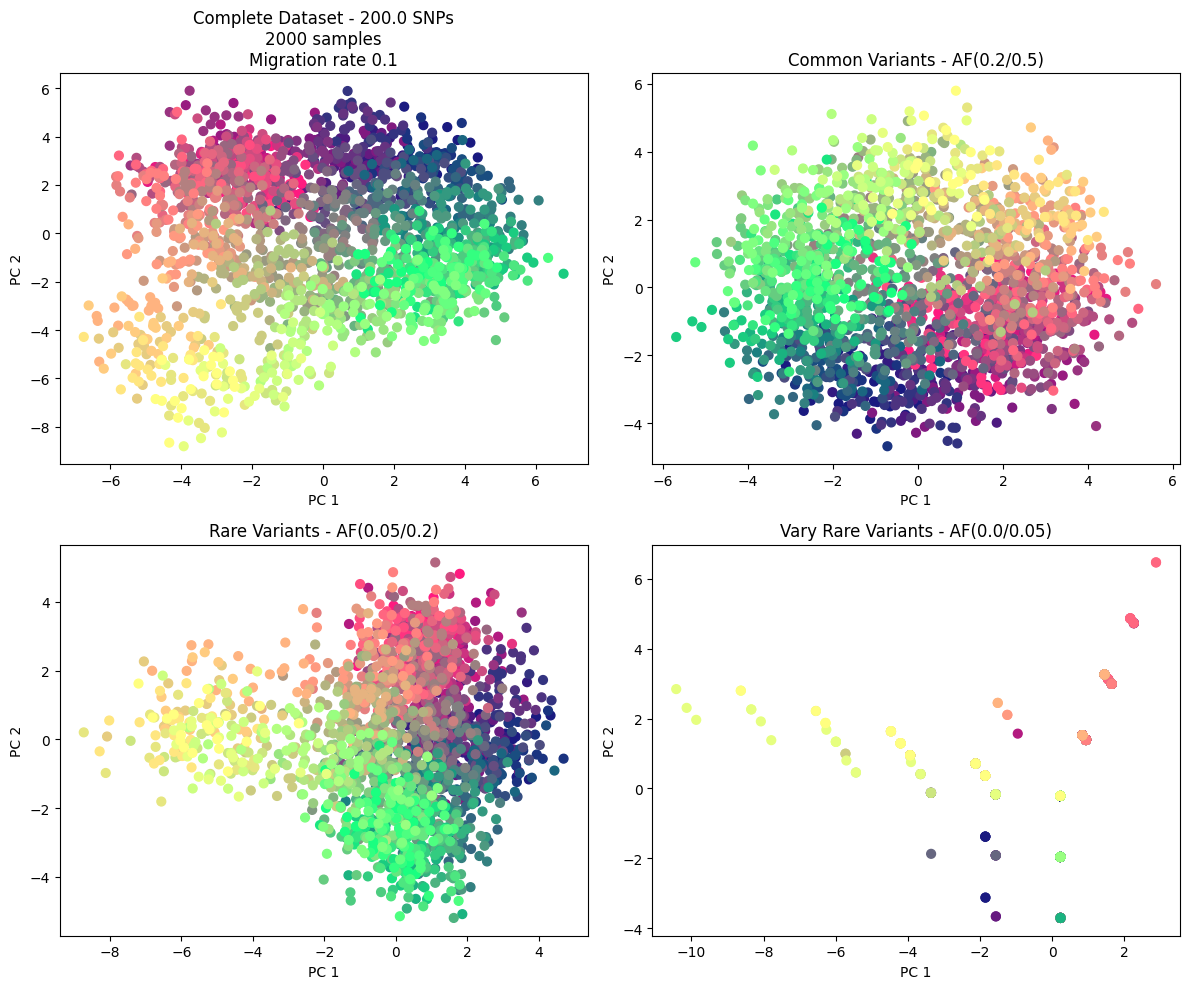

In [13]:
colors = [map_to_color(x, y, z, populations) for x, y, z in zip(populations['x'], populations['y'], populations['z'])]
# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))


dataframes = [PC_complete, PC_common, PC_rare, PC_veryrare]
titles = [f"Complete Dataset - {number_of_snps} SNPs\n{number_of_individuals} samples\nMigration rate {M}",
          f"Common Variants - AF({common_threshold_L}/{common_threshold_H})", 
          f"Rare Variants - AF({rare_threshold_L}/{rare_threshold_H})", 
          f"Vary Rare Variants - AF({very_rare_threshold_L}/{very_rare_threshold_H})"]

# Iterate through dataframes, axes, and titles
for df, ax, title in zip(dataframes, axes.flatten(), titles):
    # Count the unique values in the 'populations' column
    unique_populations = df['populations'].nunique()
    # Plotting the principal components with colors
    ax.scatter(x=df['PC1'], y=df['PC2'], c=colors, s=40)
    
    ax.set_title(title)  # Set the title for the current subplot
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.legend([],[], frameon=False) # This hides the legend


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()
plt.close()

In [14]:
"""
colors = [map_to_color(x, y, z, populations) for x, y, z in zip(populations['x'], populations['y'], populations['z'])]
# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Dataframes and corresponding titles
dataframes = [PC_complete, PC_common, PC_rare, PC_veryrare]
titles = ['Complete Dataset', 
          f"Common Variants - AF({common_threshold_L}/{common_threshold_H})", 
          f"Rare Variants - AF({rare_threshold_L}/{rare_threshold_H})", 
          f"Vary Rare Variants - AF({very_rare_threshold_L}/{very_rare_threshold_H})"]

# Iterate through dataframes, axes, and titles
for df, ax, title in zip(dataframes, axes.flatten(), titles):
    # Count the unique values in the 'populations' column
    unique_populations = df['populations'].nunique()
    # Plotting the principal components with colors
    ax.scatter(x=df['PC3'], y=df['PC4'], c=colors, s=40)
    
    ax.set_title(title)  # Set the title for the current subplot
    ax.set_xlabel('PC 3')
    ax.set_ylabel('PC 4')
    ax.legend([],[], frameon=False) # This hides the legend

# Adjust layout
plt.tight_layout()

# Show the plots
#plt.show()
plt.close()
"""

'\ncolors = [map_to_color(x, y, z, populations) for x, y, z in zip(populations[\'x\'], populations[\'y\'], populations[\'z\'])]\n# Create a figure with subplots\nfig, axes = plt.subplots(2, 2, figsize=(12, 10))\n\n# Dataframes and corresponding titles\ndataframes = [PC_complete, PC_common, PC_rare, PC_veryrare]\ntitles = [\'Complete Dataset\', \n          f"Common Variants - AF({common_threshold_L}/{common_threshold_H})", \n          f"Rare Variants - AF({rare_threshold_L}/{rare_threshold_H})", \n          f"Vary Rare Variants - AF({very_rare_threshold_L}/{very_rare_threshold_H})"]\n\n# Iterate through dataframes, axes, and titles\nfor df, ax, title in zip(dataframes, axes.flatten(), titles):\n    # Count the unique values in the \'populations\' column\n    unique_populations = df[\'populations\'].nunique()\n    # Plotting the principal components with colors\n    ax.scatter(x=df[\'PC3\'], y=df[\'PC4\'], c=colors, s=40)\n    \n    ax.set_title(title)  # Set the title for the current su

# Save PCs

In [15]:
os.makedirs(f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/phenotype/PCs",exist_ok = True)

In [16]:
PC_complete.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/phenotype/PCs/complete_genotypes_AF_0_0.5_.pkl")
PC_veryrare.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/phenotype/PCs/veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")
PC_rare.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/phenotype/PCs/rare_genotype_AF_{rare_threshold_L}_{rare_threshold_H}.pkl")
PC_common.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}_HWE{HWE}/phenotype/PCs/common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")